In [1]:
import numpy as np
from tqdm import tqdm
from IPython.display import clear_output

In [2]:
DOWN = 0
UP = 1
LEFT = 2
RIGHT = 3
actions = [DOWN, UP, LEFT, RIGHT]

Number of actions 4
Number of states 100
start state [36]
goal state(s) [ 9 22 87]
(100,)


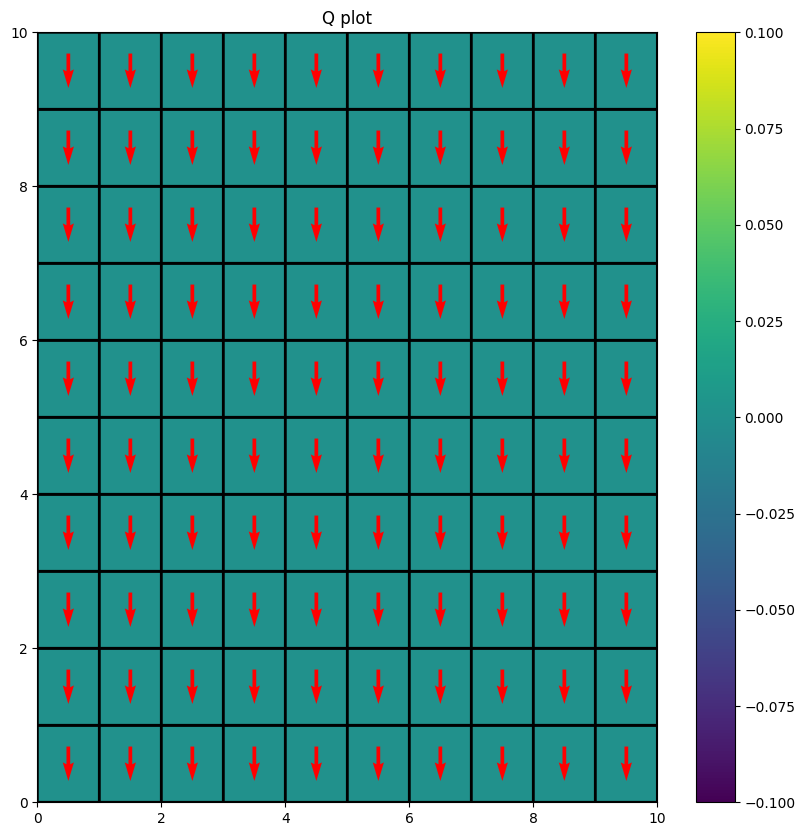

(10, 10, 4)

In [3]:
from GridWorld_PA1 import *


Q = np.zeros((env.num_rows, env.num_cols, env.num_actions))


# gw.step(gw,UP)
plot_Q(Q)

Q.shape

In [4]:
from scipy.special import softmax

seed = 42
rg = np.random.RandomState(seed)
# print(rg)

# Epsilon greedy
def choose_action_epsilon(Q, state, epsilon, rg=rg):

    # print(Q[state[0], state[1]])
    x,y=state
    action_values=Q[x,y]
    if not Q[state[0], state[1]].any() : 
        return rg.choice(len(actions)) #4 action_values  
    # TODO: return random action
    else:   
        return rg.choice([np.argmax(action_values),np.random.choice(actions)],p=[1-epsilon,epsilon])
    # TODO: return best action

# Softmax
def choose_action_softmax(Q, state, rg=rg):
    tau = 0.3
    [x,y]=state
    action_values=Q[x,y]
    # return  np.random.choice(rg,softmax)
    action_probs = softmax(action_values/tau)
    action_indices = np.arange(len(action_values))
    chosen_index=rg.choice(action_indices, p=action_probs)

    return chosen_index


In [5]:
# initialize Q-value
Q = np.zeros((env.num_rows, env.num_cols, env.num_actions))



alpha0 = 0.4
gamma = 0.9
episodes = 5000
epsilon0 = 0.1
tau = 0.3

SARSA implementation

In [6]:
print_freq = 100

def sarsa(env, Q, gamma = 0.9, plot_heat = False, choose_action = choose_action_softmax):

    episode_rewards = np.zeros(episodes)
    steps_to_completion = np.zeros(episodes)
    if plot_heat:
        clear_output(wait=True)
        plot_Q(Q)
    epsilon = epsilon0
    alpha = alpha0
    for ep in tqdm(range(episodes)):
        tot_reward, steps = 0, 0
        
        # Reset environment
        state = env.reset()
        # print(state)
        state_row_col = seq_to_col_row(state, env.num_cols)[0]
        [x,y] = state_row_col
        action = choose_action(Q, state_row_col)
        
        
        while not env.done:
            # print("action", action)
            # print(state)
            state_next, reward= env.step(state,action)
            state_next_row_col = seq_to_col_row(state_next, env.num_cols)[0]
            [x_next, y_next] = state_next_row_col
            action_next = choose_action(Q, state_next_row_col)

            #Update Q
            Q[x, y, action] = Q[x , y , action] + alpha*( reward + gamma*Q[x_next, y_next, action_next] - Q[x, y, action])
            
            tot_reward += reward
            steps += 1
            
            state, action = state_next, action_next
        
        episode_rewards[ep] = tot_reward
        steps_to_completion[ep] = steps
        
        if (ep+1)%print_freq == 0 and plot_heat:
            clear_output(wait=True)
            plot_Q(Q, message = "Episode %d: Reward: %f, Steps: %.2f, Qmax: %.2f, Qmin: %.2f"%(ep+1, np.mean(episode_rewards[ep-print_freq+1:ep]),
                                                                           np.mean(steps_to_completion[ep-print_freq+1:ep]),
                                                                           Q.max(), Q.min()))
                
    return Q, episode_rewards, steps_to_completion

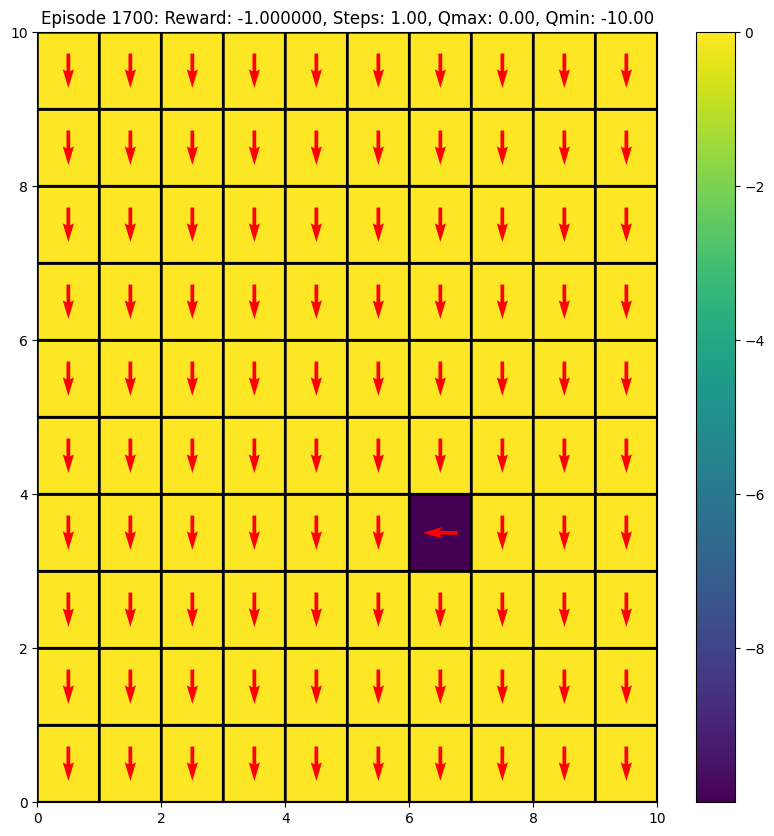

 34%|███▍      | 1700/5000 [00:08<00:15, 209.26it/s]

In [7]:
Q, rewards, steps = sarsa(gw, Q, gamma = gamma, plot_heat=True, choose_action= choose_action_softmax)